### Guassian model

We are interested in $I(X;Y)$ where $X\in R^d$. In this example we consider $d=10$.


$$
(x_i, y_i) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})\\
x_i\bot x_j\quad \forall i\neq j\\
y_i\bot y_j\quad \forall i\neq j\\
x_i\bot y_j\quad \forall i\neq j
$$
In other words, the covariance matrix of $(X_1,X_2,\dots,X_d,Y_1,Y_2,\dots,Y_d$ is equal to
$\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix}\otimes I_d$

In this case $I(X;Y)=d*I(X_1;Y_1)=-\frac{d}{2}\log(1-\rho^2)$

In [103]:
import numpy as np

In [105]:
rho=0.6
n=1000
d=3
Sigma=np.tensordot([[1,rho],[rho,1]],np.eye(d),0)
Sigma=np.reshape(Sigma,(2,2*d,d),2*d)
Sigma=np.reshape(Sigma,(2*d,2*d),0)
print(Sigma)
xy = np.random.multivariate_normal( mean=[0]*2*d,
                                  cov=Sigma,
                                 size = n)
x=xy[0:n,0:d]
y=xy[0:n,d:2*d]
data=(x,y)

[[1.  0.  0.  0.6 0.  0. ]
 [0.  1.  0.  0.  0.6 0. ]
 [0.  0.  1.  0.  0.  0.6]
 [0.6 0.  0.  1.  0.  0. ]
 [0.  0.6 0.  0.  1.  0. ]
 [0.  0.  0.6 0.  0.  1. ]]


In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

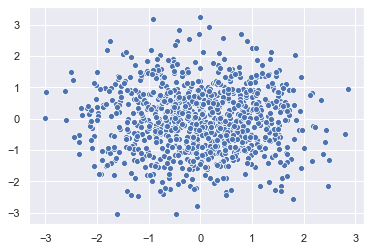

In [107]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

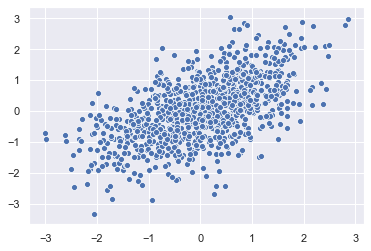

In [108]:
# plt cor Gaussian
sns.scatterplot(x=x[:,0],y=y[:,0])

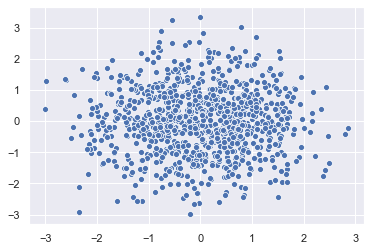

In [109]:
# plt ind Gaussian
sns.scatterplot(x=x[:,0],y=y[:,1])

# Define MINE

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [111]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.elu(self.fc1(input))
        output = F.elu(self.fc2(output))
        output = self.fc3(output)
        return output

In [112]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.2):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    #joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    joint = torch.autograd.Variable(torch.FloatTensor(joint)) #Sina
    #marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)) #Sina
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    #autograd.backward(loss)
    loss.backward() #Sina
    mine_net_optim.step()
    return mi_lb, ma_et

def learn_mine_biased(batch, mine_net, mine_net_optim):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    #joint = torch.autograd.Variable(torch.FloatTensor(joint)).cuda()
    joint = torch.autograd.Variable(torch.FloatTensor(joint)) #Sina
    #marginal = torch.autograd.Variable(torch.FloatTensor(marginal)).cuda()
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal)) #Sina
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    
    
    # use biased estimator
    loss = - mi_lb
    
    mine_net_optim.zero_grad()
    #autograd.backward(loss)
    loss.backward() #Sina
    mine_net_optim.step()
    return mi_lb

In [113]:
def sample_batch(data, batch_size=300, sample_mode='joint'):
    #Data=(X,Y) where X and Y have a dimension d
    (X,Y)=data    
    N=X.shape[0]
    if sample_mode == 'joint':
        index = np.random.choice(range(N), size=batch_size, replace=False)
        batch = np.concatenate([X[index],Y[index]],axis=1)
    else:
        index_1 = np.random.choice(range(N), size=batch_size, replace=False)
        index_2 = np.random.choice(range(N), size=batch_size, replace=False)
        batch = np.concatenate([X[index_1], Y[index_2]],axis=1)
    return batch


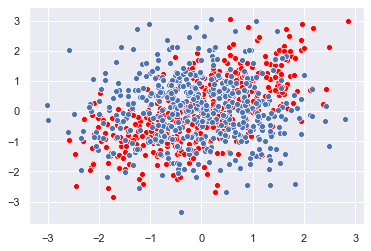

In [114]:
joint_data = sample_batch(data,batch_size=500,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,d],color='red')
marginal_data = sample_batch(data,batch_size=500,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,d])

In [115]:
def train(data, mine_net,mine_net_optim, batch_size=300, iter_num=int(5e+3), log_freq=int(1e+3), Unbiased=True):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')        
        if Unbiased:            
            #Unbiased
            mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        else:            
            #Biased
            mi_lb= learn_mine_biased(batch, mine_net, mine_net_optim)
            
        result.append(mi_lb.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [116]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [117]:
#mine_net_indep = Mine().cuda()
mine_net= Mine(input_size=2*d) #Sina
mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-3)

print('Unbiased')
result = train(data,mine_net,mine_net_optim)



Unbiased
0.73825854
0.732095
0.5665945
0.7187812
0.8033988


In [128]:
print("Averaged Estimated MI: ",sum(np.asarray(result[-100:-1]))/100 )
True_MI=-0.5*d*np.log(1-rho**2)
print("True_MI: ",True_MI)

Averaged Estimated MI:  0.6734527373313903
True_MI:  0.6694306539426292


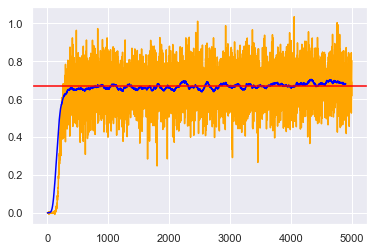

In [136]:

result_ma = ma(result)
plt.plot(range(len(result)),result,color='orange')+plt.plot(range(len(result_ma)),result_ma,color='blue') 
plt.axhline(True_MI,xmin=0,xmax=len(result),color='red')
plt.show()